Import all the libraries required for this notebook

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import requests
import io
import urllib.parse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from PIL import Image  # Image utilities.
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import imageio as io_temp
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from PIL import Image


cudnn.benchmark = True
plt.ion()   # interactive mode

Downloading the dataset from online resources

In [2]:
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


In [3]:
BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

# Read in csv files.
train = read_csv_from_web('train.csv')
test = read_csv_from_web('test.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [4]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [5]:
test.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [6]:
train.shape, test.shape

((2145, 3), (490, 2))

In [7]:
print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")

There are 100 unique turtles in the train set.


In [8]:
train_images_per_turtle = pd.value_counts(train['turtle_id'])

In [9]:
train_images_per_turtle

t_id_ROFhVsy2    77
t_id_hRzOoJ2t    68
t_id_VP2NW7aV    58
t_id_Kf73l69A    57
t_id_G5eoqwD8    47
                 ..
t_id_ifWwxWF4    10
t_id_Dv4O8bOM    10
t_id_p77GDtzg     9
t_id_OqU1NWEA     9
t_id_J5dngbNA     8
Name: turtle_id, Length: 100, dtype: int64

Capturing all the turtle IDs and assigning a number to each turtle

In [10]:
ls = pd.unique(train['turtle_id'])
classes = {}
for i in range(len(ls)):
    classes[ls[i]] = i
class_names = classes

In [11]:
num_classes = len(class_names)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train[['image_id','image_location']], train['turtle_id'], test_size=0.20, random_state=42, stratify=train['turtle_id'])
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42, stratify=y_test)

print(X_train.shape, X_test.shape, X_val.shape ,y_train.shape, y_test.shape, y_val.shape)

train_ds = pd.concat([X_train, y_train], axis=1)
train_ds['type'] = "train"
test_ds = pd.concat([X_test, y_test], axis=1)
test_ds['type'] = "test"
val_ds = pd.concat([X_val, y_val], axis=1)
val_ds['type'] = "val"

(1716, 2) (214, 2) (215, 2) (1716,) (214,) (215,)


In [13]:
dataset_sizes = {'train': len(train_ds), 'test': len(test_ds), 'val': len(val_ds)}

In [14]:
train_ds

,image_id,image_location,turtle_id,type
708,ID_UC0NFKIH,left,t_id_UVQa4BMz,train
59,ID_IZB1O90H,right,t_id_2QmcRkNj,train
614,ID_L4O6H0WC,top,t_id_8b8sprYe,train
2011,ID_BUYIHPE9,left,t_id_tjWepji1,train
761,ID_2HBGMZLT,right,t_id_BI99coHt,train
...,...,...,...,...
1126,ID_3JHL0XDW,left,t_id_AOWArhGb,train
697,ID_DBYS9YUA,right,t_id_uJXT7dGu,train
165,ID_XAO3YF62,top,t_id_D0gA44av,train
52,ID_P7LXRA4M,left,t_id_4XiPKIk7,train


In [15]:
dataset = pd.concat([train_ds,test_ds,val_ds], axis=0)

In [16]:
dataset

,image_id,image_location,turtle_id,type
708,ID_UC0NFKIH,left,t_id_UVQa4BMz,train
59,ID_IZB1O90H,right,t_id_2QmcRkNj,train
614,ID_L4O6H0WC,top,t_id_8b8sprYe,train
2011,ID_BUYIHPE9,left,t_id_tjWepji1,train
761,ID_2HBGMZLT,right,t_id_BI99coHt,train
...,...,...,...,...
1460,ID_TTABJPWV,top,t_id_AOWArhGb,val
762,ID_I9VYL0O6,top,t_id_p77GDtzg,val
2105,ID_SC9XGO7W,top,t_id_e9i3Lbq4,val
618,ID_QDJ0DNWU,top,t_id_fjHGjp1w,val


In [17]:
dataset['image_id'] = IMAGE_DIR + "/" + dataset['image_id'].astype(str) + ".JPG"

Replacing the turtle IDs with numbers for easier training by the deep learning model

In [18]:
dataset['turtle_id'] = dataset['turtle_id'].map(classes)

In [19]:
dataset.to_csv('./dataset.csv')

In [20]:
train_ds = dataset.loc[dataset['type'] == "train"]
test_ds = dataset.loc[dataset['type'] == "test"]
val_ds = dataset.loc[dataset['type'] == "val"]

In [21]:
train_ds

,image_id,image_location,turtle_id,type
708,./turtle_recall/images/ID_UC0NFKIH.JPG,left,37,train
59,./turtle_recall/images/ID_IZB1O90H.JPG,right,44,train
614,./turtle_recall/images/ID_L4O6H0WC.JPG,top,43,train
2011,./turtle_recall/images/ID_BUYIHPE9.JPG,left,38,train
761,./turtle_recall/images/ID_2HBGMZLT.JPG,right,23,train
...,...,...,...,...
1126,./turtle_recall/images/ID_3JHL0XDW.JPG,left,25,train
697,./turtle_recall/images/ID_DBYS9YUA.JPG,right,54,train
165,./turtle_recall/images/ID_XAO3YF62.JPG,top,63,train
52,./turtle_recall/images/ID_P7LXRA4M.JPG,left,26,train


Creating a Dataloader for our dataset which can be used for pytorch. This only makes use of the image data and the turtle ID. The turtles head orientation is not used

In [22]:
class TurtleDataset(Dataset):
    """Turtle dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = io_temp.imread(img_name)
        details = self.csv.iloc[idx, 1:]
        details = np.array([details])
        details = details[:1]
        sample = {'image': image, 'image_orientation': details[0][0], 'turtle_id': details[0][1]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [23]:
def show_pics(image, image_orientation, turtle_id):
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [25]:
train_ds = train_ds.iloc[:10]

0 (743, 876, 3) 37


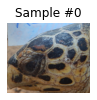

1 (1457, 1476, 3) 44


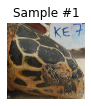

2 (291, 400, 3) 43


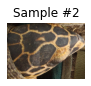

3 (708, 930, 3) 38


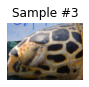

In [26]:
face_dataset = TurtleDataset(csv_file=train_ds)

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['turtle_id'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pics(**sample)

    if i == 3:
        plt.show()
        break

Rescale helps reformat the image by changing its dimensions and cropping it to allow it to be used as an input in our model

In [27]:
def get_sobel_kernel(k=3):
    # get range
    range = np.linspace(-(k // 2), k // 2, k)
    # compute a grid the numerator and the axis-distances
    x, y = np.meshgrid(range, range)
    sobel_2D_numerator = x
    sobel_2D_denominator = (x ** 2 + y ** 2)
    sobel_2D_denominator[:, k // 2] = 1  # avoid division by zero
    sobel_2D = sobel_2D_numerator / sobel_2D_denominator
    return sobel_2D

In [28]:
import cv2

In [42]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size = 224):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
#         sobel_2D = get_sobel_kernel(3)
#         self.sobel_filter_x = nn.Conv2d(in_channels=3,
#                                         out_channels=1,
#                                         kernel_size=3,
#                                         padding=3 // 2,
#                                         bias=False)
#         self.sobel_filter_x.weight[:] = torch.from_numpy(sobel_2D)

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['turtle_id'] # , sample['image_orientation']
        h, w = image.shape[:2]
        crop_size = min(w, h)
        crop = image[(h - crop_size) // 2 : (h + crop_size) // 2, (w - crop_size) // 2 : (w + crop_size) // 2]
        img = resize(crop, (self.output_size, self.output_size))
#         img_blur = cv2.GaussianBlur(img, (3,3), 0)
        img = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) * 0.5
        return [img.transpose((2,0,1)).astype(np.double),turtle_id]

In [43]:
# class Rescale(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """

#     def __init__(self, output_size = 224):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size
#         self.randomrotate = torchvision.transforms.RandomRotation(0)
#         self.greyscale =  torchvision.transforms.Grayscale(num_output_channels=1)

#     def __call__(self, sample):
#         image, turtle_id = sample['image'], sample['turtle_id'] # , sample['image_orientation']
#         image = self.randomrotate(Image.fromarray(image))
#         image = np.array(self.greyscale(image))
#         h, w = image.shape[:2]
#         crop_size = min(w, h)
#         if crop_size == h:
#             print(w,h)
#             print(256, int((256*h)/crop_size))
#             img = resize(image, (256, int((256*h)/crop_size)))
#         else:
#             img = resize(image, (int((w*256)/crop_size), 256))
#         img  = np.zeros((self.output_size,self.output_size)) + img
#         img = np.array([img] * 3)
# #         return [img.transpose((2,0,1)).astype(np.double),turtle_id]
#         return [img.astype(np.double),turtle_id]

In [44]:
train_transformed_dataset = TurtleDataset(csv_file=train_ds,
                                               transform=transforms.Compose([
                                               Rescale(256)
                                           ]))
test_transformed_dataset = TurtleDataset(csv_file=test_ds,
                                               transform=transforms.Compose([
                                               Rescale(256)
                                           ]))
val_transformed_dataset = TurtleDataset(csv_file=val_ds,
                                               transform=transforms.Compose([
                                               Rescale(256)
                                           ]))

In [45]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=2),
              'test' : DataLoader(test_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=2),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=2)}

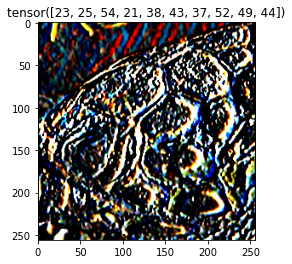

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0])

imshow(inputs[6], title=classes)

train_model is a funciton to train any model with any criterion and optimizer. We can change the model input with other pretrained models to experiment further!

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
model_ft = models.resnet18(pretrained=True) ### Can change this to try out other models available 
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Image + edge 20 epoch pretrained

In [36]:
# for i in range(5):
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=20)
torch.save(model_ft.state_dict(),"pretrained_img_plus_edge_resnet18.pth")

Epoch 0/19
----------
train Loss: 4.5209 Acc: 0.0315
val Loss: 4.3356 Acc: 0.0558

Epoch 1/19
----------
train Loss: 3.9403 Acc: 0.1317
val Loss: 4.1201 Acc: 0.0744

Epoch 2/19
----------
train Loss: 3.3285 Acc: 0.2803
val Loss: 3.9199 Acc: 0.1209

Epoch 3/19
----------
train Loss: 2.7413 Acc: 0.4522
val Loss: 3.7151 Acc: 0.1349

Epoch 4/19
----------
train Loss: 2.1177 Acc: 0.6480
val Loss: 3.5518 Acc: 0.1674

Epoch 5/19
----------
train Loss: 1.5980 Acc: 0.8298
val Loss: 3.4655 Acc: 0.1907

Epoch 6/19
----------
train Loss: 1.1658 Acc: 0.9237
val Loss: 3.3706 Acc: 0.2093

Epoch 7/19
----------
train Loss: 0.8093 Acc: 0.9802
val Loss: 3.3669 Acc: 0.2047

Epoch 8/19
----------
train Loss: 0.7715 Acc: 0.9883
val Loss: 3.3375 Acc: 0.2279

Epoch 9/19
----------
train Loss: 0.7340 Acc: 0.9895
val Loss: 3.3334 Acc: 0.2233

Epoch 10/19
----------
train Loss: 0.7002 Acc: 0.9913
val Loss: 3.3420 Acc: 0.2140

Epoch 11/19
----------
train Loss: 0.6678 Acc: 0.9948
val Loss: 3.3218 Acc: 0.2372

Ep

In [36]:
model_ft.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
for param in model_ft.parameters():#.layer4.parameters():
    print(param.requires_grad)

In [35]:
model_ft = models.resnet18(pretrained=True) ### Can change this to try out other models available 
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [127]:
# for i in range(5):
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=20)
torch.save(model_ft.state_dict(),"pretrained_img_plus_edge_resnet18.pth")

Epoch 0/19
----------
train Loss: 4.5264 Acc: 0.0367
val Loss: 4.3517 Acc: 0.0512

Epoch 1/19
----------
train Loss: 3.9282 Acc: 0.1352
val Loss: 4.1404 Acc: 0.0698

Epoch 2/19
----------
train Loss: 3.3218 Acc: 0.2937
val Loss: 3.9578 Acc: 0.1023

Epoch 3/19
----------
train Loss: 2.7075 Acc: 0.4848
val Loss: 3.7473 Acc: 0.1209

Epoch 4/19
----------
train Loss: 2.1145 Acc: 0.6742
val Loss: 3.6379 Acc: 0.1535

Epoch 5/19
----------
train Loss: 1.5742 Acc: 0.8310
val Loss: 3.5184 Acc: 0.1953

Epoch 6/19
----------
train Loss: 1.1368 Acc: 0.9400
val Loss: 3.4478 Acc: 0.2047

Epoch 7/19
----------
train Loss: 0.7751 Acc: 0.9883
val Loss: 3.4144 Acc: 0.2000

Epoch 8/19
----------
train Loss: 0.7350 Acc: 0.9918
val Loss: 3.4218 Acc: 0.2047

Epoch 9/19
----------


KeyboardInterrupt: 

In [ ]:
def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score


def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [ ]:
def test_model(model, criterion, optimizer, scheduler):

    model.eval()   # Set model to evaluate mode

    t_output = []
    t_pred = []
    y_test = []
    top_k = []
    # Iterate over data.
    i = 1
    for inputs, labels in dataloaders['test']:
        # inputs = inputs.type(torch.DoubleTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_test.append(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            t_output.append(outputs)
            t_pred.append(preds)
            temp1, temp2 = outputs.topk(5)
            top_k.append(temp2)

        i+=1
        if i == 11:
            break

    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
    y_pred = torch.cat(top_k).cpu().detach().numpy() 
    mapk_result = mapk(y_test, y_pred, k=5)
    print("With real set labels, our mapk with k=5 is", mapk_result)
    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test_num, y_test)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, y_test))

In [ ]:
test_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

In [ ]:
visualize_model(model_ft)